In [1]:
import torch
import torch.nn as nn
import os
import math
folder_name='4.1'

In [2]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim,kernel_size,out_channels):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        '''
       kenel-size表示卷积核大小
        
        feature_dim表示卷积之后的输出再经过两层神经网络得到的输出维度
        hidden_dim=2*feature_dim表示神经网络隐藏层维度
        '''
        self.feature_dim = feature_dim
        self.kernel_size=kernel_size
        self.out_channels=out_channels
        hidden_dim = 2 * feature_dim
        
        
        self.conv1 = nn.Conv1d(in_channels=self.D,out_channels=self.out_channels,kernel_size=self.kernel_size)
        self.Linear1 = nn.Linear((32-self.kernel_size+1)*self.out_channels, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.activeFun = nn.Sigmoid()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        conv_raw=self.conv1(X)
        conv=self.activeFun(conv_raw)
        dim=conv.shape[0]
        conv=conv.reshape(dim,-1)
        hidden_layer = self.Linear1(conv)
        ReLU_layer = self.activeFun(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
#         hyp = torch.log(torch.ones(self.D + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
#         hyp = torch.cat([hyp, torch.log(torch.ones(self.D + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        hyp = torch.nn.Parameter(hyp, requires_grad=True)
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        
        psi1 = rho * self.kernel(X_H, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)
        pred_u = torch.matmul(psi, alpha)
        
        return pred_u
        
#         NLML = 0.5 * torch.matmul(y.T, alpha) + \
#                torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
#         return NLML[0, 0]
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H
        L = self.L
        X_star = self.feature_get(X_star_raw)
#         X_star = X_star_raw

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))

In [3]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline  
np.random.seed(1234)
torch.manual_seed(1234)

In [4]:
def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [5]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

In [6]:
# Training data    
X_L = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
y_L = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1,1)

X_star = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
y_star = np.loadtxt('./dataset/y_train_high.txt').reshape(-1,1)

# Test data
X_H = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
y_H = np.loadtxt('./dataset/y_test_high.txt').reshape(-1,1)



In [7]:
X_L=X_L.reshape(-1,1,32)
X_H=X_H.reshape(-1,1,32)
y_L=y_L.reshape(-1,1)
y_H=y_H.reshape(-1,1)
kernel_size=25
feature_dim =128
out_channels=26

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()

# print(y_H,y_L,y_star)

In [8]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim,kernel_size,out_channels)

Total number of parameters: 261


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn=torch.nn.L1Loss()

# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [10]:
state = {'model':model.state_dict(), 'optimizer':optimizer.state_dict()}

In [11]:
# checkpoint = torch.load('18.modelParams.pth')
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])

一、

1. 先建立一个字典，保存三个参数：

state = {‘net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}

2.调用torch.save():

torch.save(state, dir)

其中dir表示保存文件的绝对路径+保存文件名，如'/home/qinying/Desktop/modelpara.pth'

二、

当你想恢复某一阶段的训练（或者进行测试）时，那么就可以读取之前保存的网络模型参数等。

checkpoint = torch.load(dir)

model.load_state_dict(checkpoint['net'])

optimizer.load_state_dict(checkpoint['optimizer'])

start_epoch = checkpoint['epoch'] + 1

In [12]:
epoches = 30000

for e in range(epoches):
    optimizer.zero_grad()
    loss = loss_fn(y_H,model())
#     if loss<0:
#         break
    if (e)%100==0:
        print(f'epoch: {e}  loss: {loss.item()}')
    loss.backward()
    optimizer.step()

epoch: 0  loss: 0.9920857548713684
epoch: 100  loss: 0.017382727935910225
epoch: 200  loss: 0.018828921020030975
epoch: 300  loss: 0.01693132147192955
epoch: 400  loss: 0.017247093841433525
epoch: 500  loss: 0.0187360979616642
epoch: 600  loss: 0.0172907505184412
epoch: 700  loss: 0.013300154358148575
epoch: 800  loss: 0.01441913191229105
epoch: 900  loss: 0.0122286481782794
epoch: 1000  loss: 0.01439666748046875
epoch: 1100  loss: 0.01411395613104105
epoch: 1200  loss: 0.01264190673828125
epoch: 1300  loss: 0.0114610455930233
epoch: 1400  loss: 0.0112978620454669
epoch: 1500  loss: 0.009585910476744175
epoch: 1600  loss: 0.0122697614133358
epoch: 1700  loss: 0.010899013839662075
epoch: 1800  loss: 0.009372287429869175
epoch: 1900  loss: 0.01091935858130455
epoch: 2000  loss: 0.009977128356695175
epoch: 2100  loss: 0.009654575027525425
epoch: 2200  loss: 0.00699615478515625
epoch: 2300  loss: 0.01137542724609375
epoch: 2400  loss: 0.007617102935910225
epoch: 2500  loss: 0.0070499842986

epoch: 20000  loss: 0.00023057725047692657
epoch: 20100  loss: 0.00024753145407885313
epoch: 20200  loss: 0.00017801921057980508
epoch: 20300  loss: 0.00030178495217114687
epoch: 20400  loss: 0.00031153360032476485
epoch: 20500  loss: 0.00015470717335119843
epoch: 20600  loss: 0.0003119574685115367
epoch: 20700  loss: 0.00019327799964230508
epoch: 20800  loss: 0.00023693508410360664
epoch: 20900  loss: 0.00017462836694903672
epoch: 21000  loss: 0.00013097126793581992
epoch: 21100  loss: 0.00019751655054278672
epoch: 21200  loss: 0.00022040473413653672
epoch: 21300  loss: 0.00015936957788653672
epoch: 21400  loss: 0.00015216403699014336
epoch: 21500  loss: 0.00018437702965456992
epoch: 21600  loss: 0.00017420451331418008
epoch: 21700  loss: 0.00021023220324423164
epoch: 21800  loss: 0.000186920166015625
epoch: 21900  loss: 0.00024202134227380157
epoch: 22000  loss: 0.00011910332250408828
epoch: 22100  loss: 0.000217437744140625
epoch: 22200  loss: 0.00015682644152548164
epoch: 22300  lo

In [13]:
X_star=torch.from_numpy(np.array(X_star).reshape(-1,1,32)).float()

In [14]:
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [15]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()

Relative L2 error u: 7.951930e-02
1.23
r2 socre: 0.35732704614072575
mse: 3.1507859443708006
[[23.59   29.0747 26.14   27.8161 30.3172 26.5041 25.4043 29.11   24.28
  27.7186 31.0396 28.8246 25.66   29.6    25.4395 27.759  26.68   25.7
  22.0351 26.9236 28.3551]]
[[25.597363 30.818012 28.673794 26.3513   29.317326 26.46362  25.74519
  29.56932  23.93789  25.280552 30.31488  30.012255 25.293015 25.409466
  25.33569  25.107716 26.35994  29.153423 23.67989  26.102993 29.386623]]
[5.2367363 4.5064383 5.358424  3.7910852 5.177159  3.9606514 4.4302173
 5.2693677 5.6154637 4.2880764 5.325704  5.161228  5.5154824 5.142656
 4.834802  4.3030357 5.4244585 5.2708755 3.8133032 4.2354383 4.777067 ]


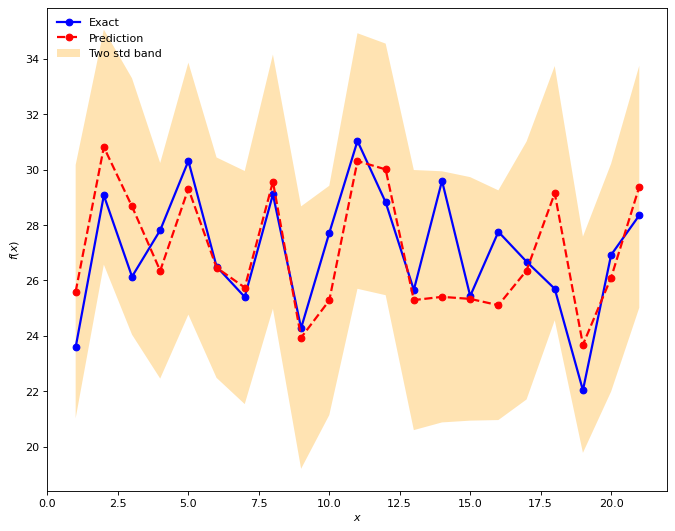

In [16]:
file_write_obj = open('4.1/4.Adam-kernel_size=25-feature_dim =128-out_channels=16-L1.txt', 'w')
# for var in mylist:
#     file_write_obj.writelines(var)
#     file_write_obj.write('\n')


# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

file_write_obj.write('Relative L2 error')
file_write_obj.write(str(error))
file_write_obj.write('\n')

index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

y_pred=np.array(y_pred)
y_star=np.array(y_star)

current=-2
current_i=0
for i in range(700):
    y_pred_a=y_pred-i*0.01
    if r2_score(y_star,y_pred_a)>current:
        current=r2_score(y_star,y_pred_a)
        current_i=i

y_pred-=current_i*0.01
print(current_i*0.01)
    

print("r2 socre:",r2_score(y_star,y_pred))
print("mse:",mean_squared_error(y_star,y_pred))

file_write_obj.write('r2 socre')
file_write_obj.writelines(str(r2_score(y_star,y_pred)))
file_write_obj.write('\n')

print(y_star.T)
print(y_pred.T)

file_write_obj.write('Exact')
file_write_obj.write(str(y_star))
file_write_obj.write('\n')

file_write_obj.write('Predict')
file_write_obj.write(str(y_pred))
file_write_obj.write('\n')

y_var_new=np.abs(np.diag(y_var))
print(y_var_new)

file_write_obj.write('std')
file_write_obj.write(str(y_var_new))
file_write_obj.write('\n')

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'o-',color='blue',label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'o--', color='red',label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig('4.1/4.Adam-kernel_size=25-feature_dim =128-out_channels=32-L1.png')
file_write_obj.close()


In [17]:
torch.save(state,'4.1/4.modelParams.pth')

In [18]:
y_pred2, y_var2 = model.predict(X_H)
y_pred2, y_var2 = y_pred2.detach().numpy(), y_var2.detach().numpy()

Relative L2 error u: 6.541114e-02
r2 socre: 0.9972255701646953
[[31.1779]
 [29.1824]
 [26.4095]
 [26.9644]
 [30.09  ]
 [26.837 ]
 [25.28  ]
 [31.4606]
 [30.1555]] [[31.274298]
 [29.239159]
 [26.500847]
 [27.193848]
 [30.175907]
 [26.925674]
 [25.391102]
 [31.527693]
 [30.2519  ]]
[0.00303841 0.00302935 0.00302315 0.00299549 0.00302458 0.00303411
 0.00301838 0.0030365  0.00302982]


Text(0, 0.5, '$f(x)$')

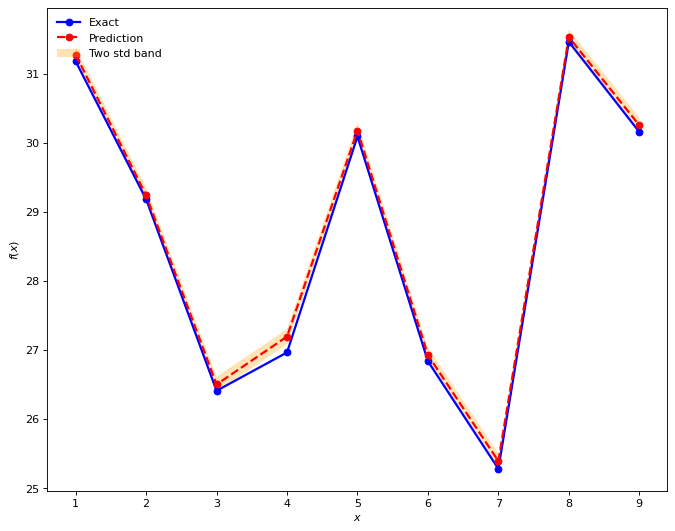

In [19]:

# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

index=[1,2,3,4,5,6,7,8,9]

y_pred2=np.array(y_pred2)
y_star2=np.array(y_H)

print("r2 socre:",r2_score(y_star2,y_pred2))

print(y_star2, y_pred2)

y_var_new2=np.abs(np.diag(y_var2))
print(y_var_new2)


# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star2, 'o-',color='blue',label = "Exact", linewidth=2)
plt.plot(index, y_pred2, 'o--', color='red',label = "Prediction", linewidth=2)


lower = np.array(y_pred2 - 2.0*np.sqrt(y_var_new2[:,None]))
upper = np.array(y_pred2 + 2.0*np.sqrt(y_var_new2[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')




30


Text(0, 0.5, '$f(x)$')

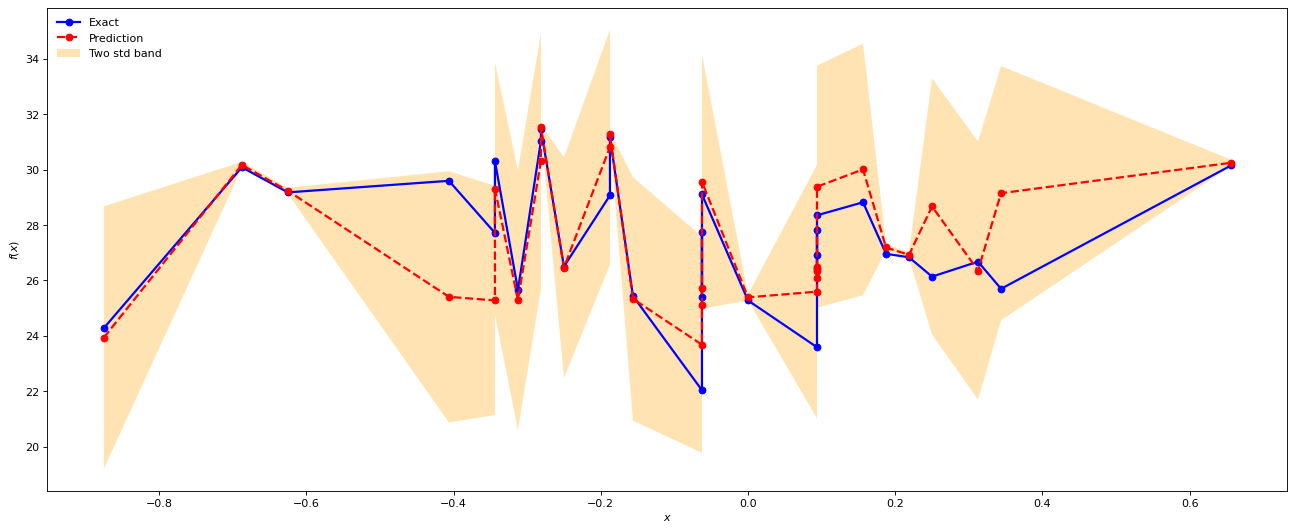

In [20]:
yyPre=np.vstack((y_pred,y_pred2))
yyExa=np.vstack((y_star,y_star2))
yyVar=np.hstack((y_var_new,y_var_new2))
xx=np.vstack((X_star,X_H)).mean(axis=2)
print(xx.size)

zipped=zip(xx,yyPre,yyExa,yyVar)
sort_zipped = sorted(zipped,key=lambda x:(x[0],x[1],x[2],x[3]))
result=zip(*sort_zipped)
X_draw,y_pred_draw,y_star_draw,y_var_draw=[list(x) for x in result]

plt.figure(1, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(X_draw, y_star_draw, 'o-',color='blue', label = "Exact", linewidth=2)
plt.plot(X_draw, y_pred_draw, 'o--', color='red',label = "Prediction", linewidth=2)

y_var_draw=np.array(y_var_draw)
lower = np.array(y_pred_draw - 2.0*np.sqrt(y_var_draw[:,None]))
upper = np.array(y_pred_draw + 2.0*np.sqrt(y_var_draw[:,None]))
                    
X_draw=np.array(X_draw)
plt.fill_between(X_draw.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')